## Loading Library

In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM , Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
import plotly.express as px
from tqdm.auto import tqdm  

c:\Users\chunl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import nltk
import re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from collections import Counter 
from string import punctuation 

In [5]:
from gensim.models import Word2Vec

## Load Dataset

In [6]:
df = pd.read_csv('clean_df.csv')

In [7]:
df.head()

,Unnamed: 0,Text,Language,Label
0,430988,i wouldnt dream of it just dont tell me stop,en,positive
1,492831,question for sec fans if ohio state pl...,en,positive
2,76161,would be a dream come true to join,en,positive
3,744328,you know whats even easier admitting y...,en,positive
4,673077,people asking where is sapnap dude he s figh...,en,positive


In [8]:
df = df.drop('Language' , axis=1)   # The cleaned df already remove language rows that are not en

In [9]:
df.head()

,Unnamed: 0,Text,Label
0,430988,i wouldnt dream of it just dont tell me stop,positive
1,492831,question for sec fans if ohio state pl...,positive
2,76161,would be a dream come true to join,positive
3,744328,you know whats even easier admitting y...,positive
4,673077,people asking where is sapnap dude he s figh...,positive


In [10]:
df = df.drop('Unnamed: 0' , axis=1)

In [11]:
df

,Text,Label
0,i wouldnt dream of it just dont tell me stop,positive
1,question for sec fans if ohio state pl...,positive
2,would be a dream come true to join,positive
3,you know whats even easier admitting y...,positive
4,people asking where is sapnap dude he s figh...,positive
...,...,...
595753,im almost maxed out on skills in p5 and a ton ...,uncertainty
595754,they called franklin graham a homophobic hate...,uncertainty
595755,there might be a tsunami coming to cuba jamai...,uncertainty
595756,i mostly draw and such i dont know a thing ab...,uncertainty


# We have 3 labels to do the sentiment analysis which are positive, negative and uncertainty

In [12]:
np.unique(df['Label'])

array(['negative', 'positive', 'uncertainty'], dtype=object)

In [13]:
df_labels = {key : value for value , key in enumerate(np.unique(df['Label']))}
df_labels

{'negative': 0, 'positive': 1, 'uncertainty': 2}

In [14]:
def getlabel(n) : 
    for x , y in df_labels.items() : 
        if y==n : 
            return x

In [15]:
labelencoder = LabelEncoder()

In [16]:
lemma = WordNetLemmatizer()

In [17]:
labels = labelencoder.fit_transform(df['Label'].values)

for data inputing into the model, We will do tokenization using nltk and remove punctuation, stop_words and lemmatization although we already clean some data from the text before in the beginning. For now, it is just a demo how the cleaning works

In [18]:
def DataPreprocessing(txt) : 
    # tokenization 
    tokens = nltk.word_tokenize(txt) 
    
    # remove puncs 
    puncs = list(punctuation) 
    words = [word for word in tokens if word not in puncs] 
    
    # remove stopwords 
    stop_words = set(stopwords.words('english')) 
    words = [word for word in words if word not in stop_words] 
    
    # Lemmatization 
    words = [lemma.lemmatize(word) for word in words] 
    
    txt = ' '.join(words) 
    
    return txt

In [19]:
df['text_clean'] = df['Text'].apply(DataPreprocessing) # apply the preprocessing data into the df_text

## Prepare for W2V

We applied word2vec for the embedding matrix but creating a Text to Vector function to apply to the w2v

In [20]:
df['total_length'] = [len(text.split()) for text in df.Text]  #Checking the length for each row

In [21]:
df

,Text,Label,text_clean,total_length
0,i wouldnt dream of it just dont tell me stop,positive,wouldnt dream dont tell stop,10
1,question for sec fans if ohio state pl...,positive,question sec fan ohio state player could hang ...,39
2,would be a dream come true to join,positive,would dream come true join,8
3,you know whats even easier admitting y...,positive,know whats even easier admitting never ever kn...,39
4,people asking where is sapnap dude he s figh...,positive,people asking sapnap dude fighting dream bc dr...,19
...,...,...,...,...
595753,im almost maxed out on skills in p5 and a ton ...,uncertainty,im almost maxed skill p5 ton social link waiti...,25
595754,they called franklin graham a homophobic hate...,uncertainty,called franklin graham homophobic hate preache...,39
595755,there might be a tsunami coming to cuba jamai...,uncertainty,might tsunami coming cuba jamaica amp florida ...,14
595756,i mostly draw and such i dont know a thing ab...,uncertainty,mostly draw dont know thing graphic design may...,25


In [22]:
np.max(df['total_length'])

83

In [23]:
def Vectorization(texts , MAXLEN = 83) : 
    text = df[texts].tolist() 
    
    # build vocabulary 
    corpus = [word for text in df[texts] for word in text.split()] 
    vocab_size = len(Counter(corpus)) 
    
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" , 
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )
    
    tokenizer.fit_on_texts(text) 
    
    tokenizer.word_index['<pad>'] = 0 
    tokenizer.index_word[0] = '<pad>' 
    
    # Text Vectorization 
    seq = tokenizer.texts_to_sequences(text) 
    
    pad_seqs = pad_sequences(seq , maxlen = MAXLEN , padding = 'post') 
    
    return pad_seqs , tokenizer

In [24]:
seqs , tokenizer = Vectorization('Text') # getting the padded sequences and the tokenizer

In [25]:
num_rows_to_display = 2 # we can now get the vector to form a text data

for i in range(min(num_rows_to_display, len(seqs))):
    seq_sent = ' '.join([tokenizer.index_word[idx] for idx in seqs[i] if idx != 0])
    print(f"Original Sequence {i + 1}: {seqs[i]}\nText Representation: {seq_sent}\n")

Original Sequence 1: [  5 592 151   7  10  33  94 272  38 251   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
Text Representation: i wouldnt dream of it just dont tell me stop

Original Sequence 2: [ 123   13 3825  600   30 3239  316  447  128   22 1884   11    2 3825
  106   20   26  136   59    6  121  116   52 7157  102   11    2  220
 1992  106    8   71 1604    3    2 1297   23  109   91    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
Text Representation: question for sec fans if ohio state players could not hang in the sec why are they going there and being way m

In [26]:
vocab_length = len(tokenizer.word_index)   
max_length = np.max(df['total_length']) # 83 is the max number of the text length

In [27]:
def split_text(text):
    return text.split()

In [28]:
text_data = df['Text'].tolist() # get the text data from the dataset

In [29]:
word2vec_train = list(map(split_text, text_data))    # using the split text for the function to for a list for the training data for the w2v model

In [30]:
word2vec_model = Word2Vec(word2vec_train , vector_size = 128)   
# we are picking 128 as it is the power of 2 and also we don't want to have a small value as the data we have the max_length of 83 for 1 row and also the number of row of the dataset are huge. Logically 128 should fit, if it is small, or having bad accuracy, we will change it.
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index)) 

Vocabulary Length: 49477


In [31]:
embedding_matrix = np.zeros((vocab_length , 128)) # VOCAB_SIZE is the number of unique vocabulary  
for word , token in tokenizer.word_index.items() : 
    if word in word2vec_model.wv :  #Check if the word is present in the Word2Vec model's vocabulary
        embedding_matrix[token] = word2vec_model.wv[word]   #assign the pre-trained word vector to the embedding matrix
        
print(embedding_matrix.shape)

(223787, 128)


In [32]:
seq_labels = tf.keras.utils.to_categorical(labels , len(np.unique(labels))) # one-hot encoding

In [33]:
print(f'before one hot : {labels.shape}')
print(f'after one hot : {seq_labels.shape}') # check if the number of class wrong

before one hot : (595758,)
after one hot : (595758, 3)


In [34]:
x_train , x_val , y_train , y_val = train_test_split(seqs , seq_labels , train_size = 0.8, random_state = 42)

In [35]:
x_train.shape , x_val.shape , y_train.shape , y_val.shape

((476606, 83), (119152, 83), (476606, 3), (119152, 3))

In [36]:
train_set = tf.data.Dataset.from_tensor_slices((x_train , y_train))  #BUFFER_SIZE controls the number of elements in the buffer used for shuffling
train_set = train_set.shuffle(1000).batch(128 , drop_remainder = True)   #random data order might perform better for training model

val_set = tf.data.Dataset.from_tensor_slices((x_val , y_val))
val_set = val_set.batch(128 , drop_remainder = True)

In [37]:
print(f"{len(train_set)} batches of {128}")

3723 batches of 128


In [38]:
print(f"{len(val_set)} batches of {128}")

930 batches of 128


# Building Model 

In [40]:
model = Sequential()

In [41]:
model.add(Embedding(
    input_dim=vocab_length,
    output_dim=128,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False
))


model.add(Bidirectional(LSTM(64)))  # pairing with the output dim
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) # prevent overfitting
model.add(Dense(3, activation='softmax')) # softmax applied because it is a multi-class case


The rationale behind setting the LSTM layer to 64  is to maintain consistency in the architecture's dimensions. 

Initially, the final layer was predetermined as Dense(3) to accommodate the three classes.

For the second Dense layer, a decision was made to assign it 64.

To ensure consistent across layers, this value was derived from the output dimensions of both the Embedding layer and the Bidirectional LSTM layer. This approach aims to align and harmonize the dimensions throughout the entire model.

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 83, 128)           28644736  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 28,752,003
Trainable params: 107,267
Non-trainable params: 28,644,736
______________________________________

In [43]:
model.compile(optimizer='adam', # Adam is a common optimizer, base on adaptive learning rates, and I use it in my other courses and get a pretty good result as reasons why I am choosing Adam.
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall']) # categorical_crossentropy is suitable since we use one hot as our encoding

In [44]:
history = model.fit(
    train_set , 
    epochs = 5 , 
    validation_data = val_set
)

Epoch 1/5


3723/3723 [==============================] - 330s 88ms/step - loss: 0.0921 - accuracy: 0.9623 - precision: 0.9699 - recall: 0.9560 - val_loss: 0.0582 - val_accuracy: 0.9752 - val_precision: 0.9755 - val_recall: 0.9748
Epoch 2/5
3723/3723 [==============================] - 370s 99ms/step - loss: 0.0606 - accuracy: 0.9750 - precision: 0.9761 - recall: 0.9738 - val_loss: 0.0575 - val_accuracy: 0.9753 - val_precision: 0.9756 - val_recall: 0.9751
Epoch 3/5
3723/3723 [==============================] - 406s 109ms/step - loss: 0.0585 - accuracy: 0.9755 - precision: 0.9765 - recall: 0.9744 - val_loss: 0.0575 - val_accuracy: 0.9758 - val_precision: 0.9761 - val_recall: 0.9755
Epoch 4/5
3723/3723 [==============================] - 519s 139ms/step - loss: 0.0570 - accuracy: 0.9760 - precision: 0.9770 - recall: 0.9750 - val_loss: 0.0576 - val_accuracy: 0.9763 - val_precision: 0.9768 - val_recall: 0.9758
Epoch 5/5
3723/3723 [==============================] - 541s 145ms/step - loss: 0.0557 - accuracy


We conducted training for 5 epochs, completing the process in approximately 30 minutes.

The outcomes show commendable training and validation accuracy.

We attribute this success to the abundance of data, coupled with the balanced distribution across all classes in the dataset.

In [46]:
train_loss = history.history['loss'][-1]
train_acc = history.history['accuracy'][-1]
train_precision = history.history['precision'][-1]
train_recall = history.history['recall'][-1]
train_f1_score = (2 * train_precision * train_recall) / (train_precision + train_recall)

val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_precision = history.history['val_precision'][-1]
val_recall = history.history['val_recall'][-1]
val_f1_score = (2 * val_precision * val_recall) / (val_precision + val_recall)

In [47]:
print(f"Training loss: {train_loss}\n")
print(f"Training accuracy: {train_acc}\n")
print(f"Training precision: {train_precision}\n")
print(f"Training recall: {train_recall}\n")
print(f"F1 score: {train_f1_score}\n")

Training loss: 0.05571407079696655

Training accuracy: 0.976722002029419

Training precision: 0.9776930809020996

Training recall: 0.9758322238922119

F1 score: 0.9767617661048711



In [48]:
print(f"Validation loss: {val_loss}\n")
print(f"Validation accuracy: {val_acc}\n")
print(f"Validation precision: {val_precision}\n")
print(f"Validation recall: {val_recall}\n")
print(f"F1 score: {val_f1_score}\n")

Validation loss: 0.05907098203897476

Validation accuracy: 0.9758904576301575

Validation precision: 0.9767265915870667

Validation recall: 0.9751511812210083

F1 score: 0.9759382506270805



In [50]:
model.save("sen_model_blstm.tf")

INFO:tensorflow:Assets written to: sen_model_blstm.tf\assets


INFO:tensorflow:Assets written to: sen_model_blstm.tf\assets


In [51]:
model.save("sen_model_blstm.h5")

In [52]:
model.save_weights("sen_weight_blstm.h5")

In [53]:
model.save_weights("sen_weight_blstm.tf")

## More Exploration

In [54]:
new_model = tf.keras.models.load_model("sen_model_blstm.tf")

In [55]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 83, 128)           28644736  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 28,752,003
Trainable params: 107,267
Non-trainable params: 28,644,736
______________________________________

In [56]:
new_model.load_weights("sen_weight_blstm.h5")

In [57]:
random_data = df.sample(n = 100) 
random_text = random_data['Text'].values 
true_test = random_data['Label'].values

testing_set = pad_sequences(tokenizer.texts_to_sequences(random_text) , maxlen=max_length , padding = 'post')


true_test

array(['uncertainty', 'positive', 'positive', 'positive', 'negative',
       'negative', 'positive', 'uncertainty', 'negative', 'positive',
       'uncertainty', 'uncertainty', 'negative', 'positive',
       'uncertainty', 'positive', 'positive', 'uncertainty',
       'uncertainty', 'uncertainty', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'uncertainty', 'uncertainty',
       'uncertainty', 'uncertainty', 'positive', 'uncertainty',
       'positive', 'positive', 'uncertainty', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'uncertainty', 'negative', 'positive', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'uncertainty', 'negative', 'negative', 'negative',
       'uncertainty', 'negative', 'positive', 'uncertainty', 'negative',
       'negative', 'negative', 'positive', 'positive', 'uncertainty',
       'uncertainty', 'negative', 'positi

In [58]:
prediction = new_model.predict(testing_set).round() 

4/4 [==============================] - 1s 10ms/step


In [59]:
array_from_tuple = np.array(prediction)
mappings = {
    tuple([1., 0., 0.]): 'negative',
    tuple([0., 1., 0.]): 'positive',
    tuple([0., 0., 1.]): 'uncertainty'
    # Add more mappings as needed
}

In [60]:
mapped_labels = []
for row in array_from_tuple:
    for subarray, label in mappings.items():
        if np.array_equal(row, subarray):
            mapped_labels.append(label)
            break
    else:
        # If no match is found, you can handle it as needed
        mapped_labels.append('Unknown')

# Print the resulting mapped labels
print(mapped_labels)

['uncertainty', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'uncertainty', 'uncertainty', 'negative', 'positive', 'uncertainty', 'positive', 'positive', 'uncertainty', 'uncertainty', 'uncertainty', 'negative', 'positive', 'negative', 'uncertainty', 'negative', 'negative', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'positive', 'negative', 'uncertainty', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'uncertainty', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'uncertainty', 'negative', 'negative', 'negative', 'uncertainty', 'negative', 'positive', 'uncertainty', 'negative', 'negative', 'negative', 'positive', 'positive', 'uncertainty', 'uncertainty', 'positive', 'positive', 'positive', 'positive', 'positive', 'uncertainty', 'negative', 'negative', 'positive', 'positive', 

In [61]:
cm = confusion_matrix(true_test, mapped_labels)

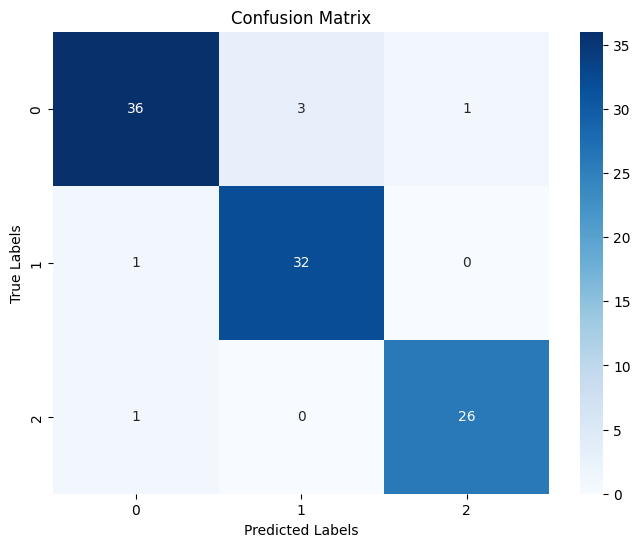

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [64]:
def make_predictions(row) : 
    random_data = row.sample(n = 3) 
    random_text = random_data['Text'].values 
    y_test = random_data['Label'].values
    
    x_test = pad_sequences(tokenizer.texts_to_sequences(random_text) , maxlen=max_length , padding = 'post')
    
    test_preds = new_model.predict(x_test).round() 
    
    for i in tqdm(range(3)) : 
        print(f"The original text : {random_text[i]}\n")
        print(f"The original label : {y_test[i]}\n")
        print(f"The prediction is : {getlabel(test_preds[i].argmax())}\n")
        
make_predictions(df)

1/1 [==============================] - 0s 21ms/step


100%|██████████| 3/3 [00:00<?, ?it/s]

The original text : it s very possible that i just tried to write the past tense of  seek  as  suck  then couldn t figure out why it looked so wrong   can neither confirm nor deny but it may have happened

The original label : uncertainty

The prediction is : uncertainty

The original text :   yes  indeed  while its already possible to deport such individuals the new terrorist law will make it easier  there are other improvements as well and that this will be a comprehensive law 

The original label : positive

The prediction is : positive

The original text :  good morning 

The original label : positive

The prediction is : positive



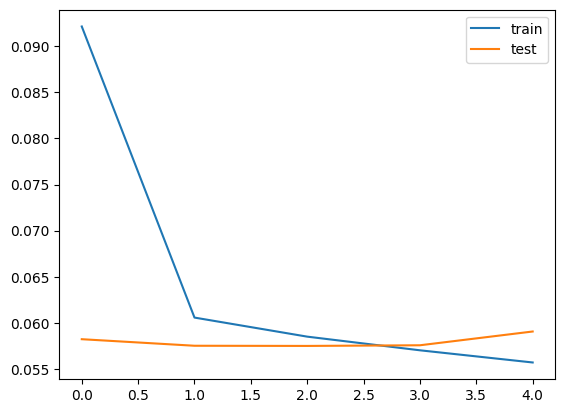

In [65]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label= 'train')
plt.plot(history.history['val_loss'],label= 'test')
plt.legend()

In [ ]:

plt.plot(history.history['accuary'],label= 'train')
plt.plot(history.history['val_loss'],label= 'test')
plt.legend()

In [72]:
num_classes = len(labelencoder.classes_)

In [71]:
true_test

array(['uncertainty', 'positive', 'positive', 'positive', 'negative',
       'negative', 'positive', 'uncertainty', 'negative', 'positive',
       'uncertainty', 'uncertainty', 'negative', 'positive',
       'uncertainty', 'positive', 'positive', 'uncertainty',
       'uncertainty', 'uncertainty', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'uncertainty', 'uncertainty',
       'uncertainty', 'uncertainty', 'positive', 'uncertainty',
       'positive', 'positive', 'uncertainty', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'uncertainty', 'negative', 'positive', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'uncertainty', 'negative', 'negative', 'negative',
       'uncertainty', 'negative', 'positive', 'uncertainty', 'negative',
       'negative', 'negative', 'positive', 'positive', 'uncertainty',
       'uncertainty', 'negative', 'positi

In [69]:
y_pred_prob = array_from_tuple

In [75]:
y_pred_prob

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0

In [81]:
label_binarizer = LabelBinarizer()
true_test_bin = label_binarizer.fit_transform(true_test)

In [82]:
fpr = dict()
tpr = dict()
roc_auc = dict()

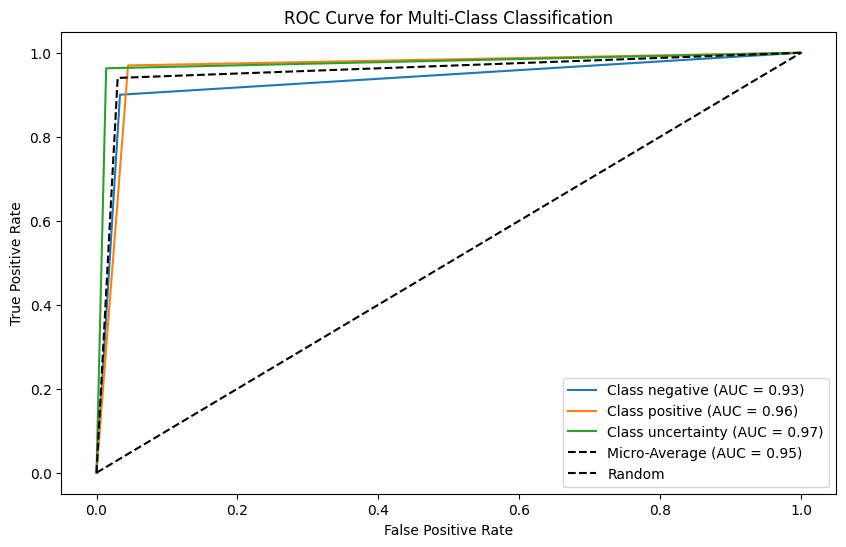

In [84]:

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(true_test_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {labelencoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr_micro, tpr_micro, label=f'Micro-Average (AUC = {roc_auc_micro:.2f})', linestyle='--', color='black')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

## Area Under the Curve (AUC) in Multi-Class

AUC is a scalar metric derived from the ROC curve, summarizing the model's overall performance. In the context of multi-class classification, the AUC is often calculated using the micro-average or macro-average:

### Micro-Average ROC AUC

- The micro-average aggregates the contributions of all classes, treating each sample-class pair equally. It is suitable for imbalanced datasets.

### Macro-Average ROC AUC

- The macro-average calculates the ROC AUC for each class independently and then averages the results. It gives equal weight to each class, providing insights into the model's performance across diverse classes.

## Interpretation
- AUC values range from 0 to 1, where a higher value indicates better discrimination between classes.
- An AUC of 0.5 suggests random performance, while an AUC of 1.0 indicates perfect discrimination.


## Reason Why we do not apply Batch Normalization

- After that, we want to do one more rnn for batch normalization to see the difference

- Since we have a good accuracy, we believe batch normalization won't have better accuracy.

- Also if we want to apply batch normalization, we have to remove the dropout layer, because they have similar role

- By searching article about batch normalization, we have known that batch normalization won't improve sentiment analysis. Ref:https://cs224d.stanford.edu/reports/MargaritSubramaniam.pdf